# Run it yourself!

Change the file path to lead to your photo of choice, then run all!

In [57]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.feature import structure_tensor, structure_tensor_eigenvalues
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Enter your own path below and run all!

In [58]:
img0 = cv2.imread("test_images/midd.jpg", cv2.IMREAD_COLOR)

Ignore all of this and scroll to the bottom to view your image!

In [59]:
h0, w0 = img0.shape[:2]
new_w  = 1388
new_h  = int(new_w * h0 / w0)
img = cv2.resize(img0, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
r = 3

In [60]:
class RidgeClassifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc3(x))

In [ ]:
def compute_ST(patch, sigma=1.0, window_size=7):
    patch_uint8 = (patch*255).astype(np.uint8)
    gray = cv2.cvtColor(patch_uint8, cv2.COLOR_RGB2GRAY) / 255.0

    Jxx, Jxy, Jyy = structure_tensor(gray, sigma=sigma)

    ST = np.array([Jxx, Jxy, Jyy])
    l1, l2 = structure_tensor_eigenvalues(ST)
    strength = np.sqrt(l1)
    coherence = (l1 - l2) / (l1 + l2 + 1e-12)
    orientation = 0.5 * np.arctan2(2*Jxy, Jxx - Jyy)

    cy = window_size//2

    strength = strength[cy, cy]
    coherence = coherence[cy, cy]
    orientation = orientation[cy, cy]

    return strength, coherence, orientation

In [62]:
def get_patch(image, x, y, r):
    h, w = image.shape[:2]
    if y - r < 0 or y + r + 1 > h or x - r < 0 or x + r + 1 > w:
        return None
    return image[y - r:y + r + 1, x - r:x + r + 1]

In [ ]:
def find_ridge_new(image, model, mode='orig', bins=None, r=3,threshold=0.8,max_restart=10,sigma=1.0,window_size=7):
    # sage way

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mdl = model.to(device).eval()
    h, w = image.shape[:2]

    # helper to build a feature vector for a patch
    def build_feat(patch):
        flat = patch.astype(np.float32).ravel() / 255.0

        if mode == 'orig':
            return flat

        s, c, o = compute_ST(patch, sigma=sigma, window_size=window_size)

        if mode == 'st':
            return np.concatenate([flat, [s, c, o]]).astype(np.float32)

        # mode == 'bkt' # BLADE method

        # strength bins
        n_s = len(bins['strength']) - 1
        sb = np.digitize(s, bins['strength']) - 1
        sb = np.clip(sb, 0, n_s-1)
        s_one = np.eye(n_s)[sb]

        # coherence bins
        n_c = len(bins['coherence']) - 1
        cb = np.digitize(c, bins['coherence']) - 1
        cb = np.clip(cb, 0, n_c-1)
        c_one = np.eye(n_c)[cb]

        # orientation bins
        n_o = len(bins['orientation']) - 1
        ob = np.digitize(o, bins['orientation']) - 1
        ob = np.clip(ob, 0, n_o-1)
        o_one = np.eye(n_o)[ob]

        return np.concatenate([flat, s_one, c_one, o_one]).astype(np.float32)

    # pick starting row by classifying x = r column
    first_probs = []
    for y in range(r, h-r):
        patch = get_patch(image, r, y, r)
        if patch is None:
            first_probs.append(0.0)
        else:
            feat = build_feat(patch)
            inp  = torch.from_numpy(feat).unsqueeze(0).to(device)
            with torch.no_grad():
                first_probs.append(mdl(inp).item())

    pad = [0.0]*r
    col = pad + first_probs + pad
    sorted_col = sorted(col, reverse=True)
    start = col.index(sorted_col[0])

    # walk across columns
    ridge, ridge_probs = [start]*r, [1.0]*r
    x, restarts = r, 0

    while x < w - r:
        neigh = []
        for dy in range(-r, r+1):
            y0 = ridge[-1] + dy
            patch = get_patch(image, x, y0, r)
            if patch is None:
                neigh.append(0.0)
            else:
                feat = build_feat(patch)
                inp  = torch.from_numpy(feat).unsqueeze(0).to(device)
                with torch.no_grad():
                    neigh.append(mdl(inp).item())

        offset = int(np.argmax(neigh)) - r
        new_y  = ridge[-1] + offset
        ridge.append(new_y)
        ridge_probs.append(neigh[offset + r])

        # adaptive restart
        if np.mean(ridge_probs) < threshold and restarts < max_restart:
            restarts += 1
            start = col.index(sorted_col[restarts])
            ridge, ridge_probs = [start]*r, [1.0]*r
            x = r
            continue

        x += 1

    return ridge

In [64]:
def plot_ridge(ridge, img):
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.plot(range(len(ridge)), ridge, color='red', linewidth=1, label='Ridge Line')
    plt.title('Ridge Line on Original Image')
    plt.xlabel('X (column)')
    plt.ylabel('Y (row)')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Original Model (without Structure Tensor)

You may need to fidget with the hyperparameters to get the best results.

- `threshold` controls when you begin adaptive restarts
- `max_restart` controls how many adaptive restarts you can do

In [65]:
m0 = RidgeClassifier(in_dim=147)
m0.load_state_dict(torch.load('models/ridge_orig_5.pth'))
m0.eval()
m0.to(device)

RidgeClassifier(
  (fc1): Linear(in_features=147, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

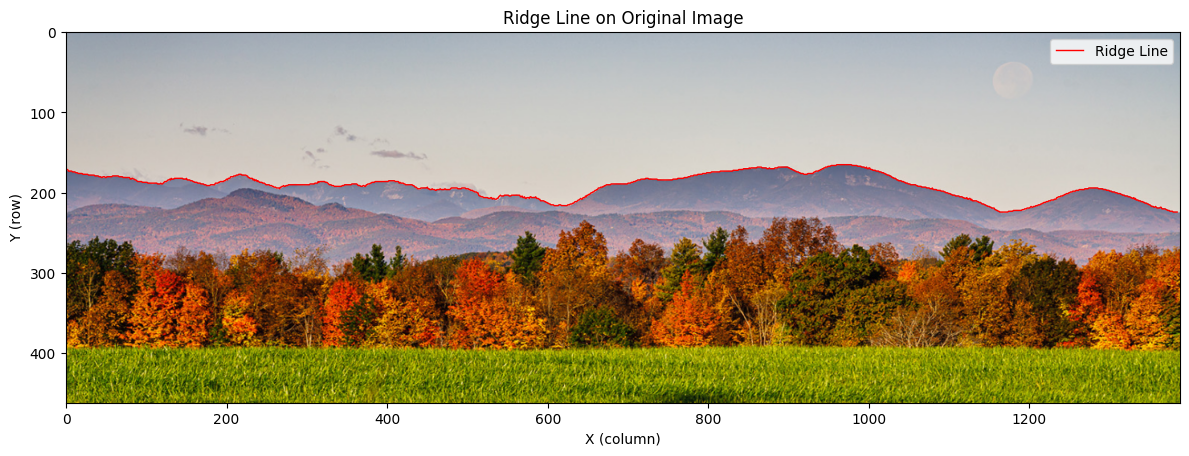

In [66]:
ridge0 = find_ridge_new(img, m0, mode='orig', threshold=0.95, r=3, max_restart=2)
plot_ridge(ridge0, img)

## SAGE Model (with Structure Tensor)

In [67]:
m1 = RidgeClassifier(in_dim=150)
m1.load_state_dict(torch.load('models/ridge_st_cont_5.pth'))
m1.eval()   
m1.to(device)

RidgeClassifier(
  (fc1): Linear(in_features=150, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

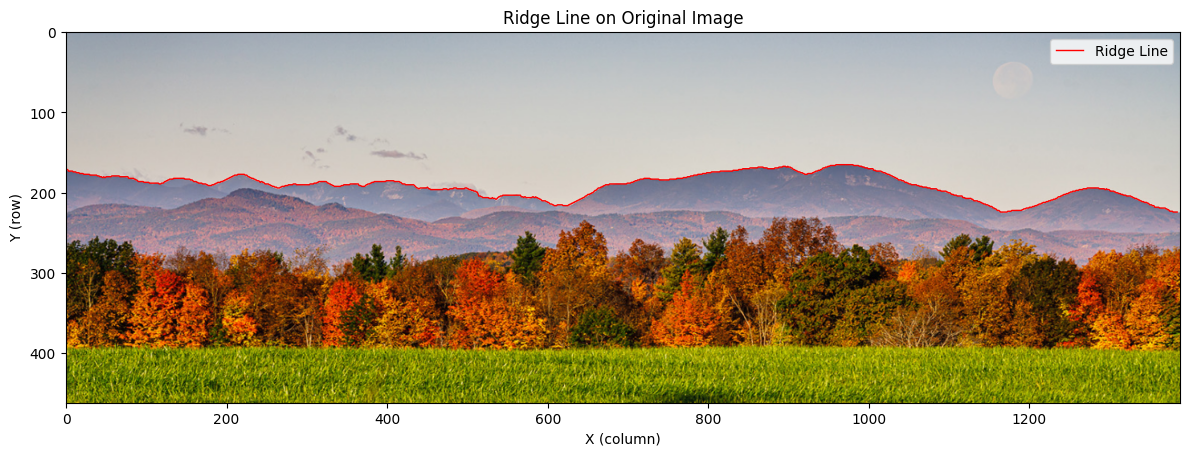

In [68]:
ridge1 = find_ridge_new(img, m1, mode='st', r=3, threshold=0.95, max_restart=2)
plot_ridge(ridge1, img)

*The models used in this example code were trained on our whole dataset and use a slow `skimage` method to capture structure tensor data. In other words deprecated, but still shows our greedy algorithm approach, it's strengths and its weaknesses*